<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80_%D0%B0%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Примеры автоэнкодеров

В этом ноутбуке использованы примеры из статьи: https://habr.com/ru/post/331382/

Загрузим уже известный нам набор данных MNIST с рукописными цифрами.

In [ ]:
try:
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    os.chdir('/content/drive/My Drive/Colab Notebooks/')
except ImportError:
    pass


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


## Сжимающий автоэнкодер

Рассмотрим самый простой сжимающий автоэнкодер: входные данные - наши картинки - имеют размерность 28 * 28 = 784 признака, а код на выходе энкодера пусть будет размерностью 49 признаков.

In [ ]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model

def create_dense_ae():
    # Размерность кодированного представления
    encoding_dim = 49

    # Энкодер
    # Входной плейсхолдер
    input_img = Input(shape=(28, 28, 1)) # 28, 28, 1 - размерности строк, столбцов, фильтров одной картинки, без батч-размерности
    # Вспомогательный слой решейпинга
    flat_img = Flatten()(input_img)
    # Кодированное полносвязным слоем представление
    encoded = Dense(encoding_dim, activation='relu')(flat_img)

    # Декодер
    # Раскодированное другим полносвязным слоем изображение
    input_encoded = Input(shape=(encoding_dim,))
    flat_decoded = Dense(28*28, activation='sigmoid')(input_encoded)
    decoded = Reshape((28, 28, 1))(flat_decoded)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать как и слои
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

Скомпилируем нашу модель

In [ ]:
encoder, decoder, autoencoder = create_dense_ae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 49)                38465     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         39200     
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________


Обучаем модель

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))




Train on 60000 samples, validate on 10000 samples
Epoch 1/50





60000/60000 [==============================] - 5s 87us/step - loss: 0.2581 - val_loss: 0.1739
Epoch 2/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.1542 - val_loss: 0.1363
Epoch 3/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.1276 - val_loss: 0.1178
Epoch 4/50
60000/60000 [==============================] - 4s 75us/step - loss: 0.1126 - val_loss: 0.1058
Epoch 5/50
60000/60000 [==============================] - 4s 73us/step - loss: 0.1025 - val_loss: 0.0974
Epoch 6/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.0955 - val_loss: 0.0915
Epoch 7/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.0905 - val_loss: 0.0874
Epoch 8/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.0871 - val_loss: 0.0847
Epoch 9/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.0847 - val_loss: 0.08

Напишем функцию, которая будет выводить картинки на экран

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])

    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

Давайте посмотрим на то, как одно из наших изображений будет представлено в полученном коде:

In [ ]:
n = 10

imgs = x_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)
encoded_imgs[0]

array([ 5.674725 ,  8.473352 ,  3.3438928,  5.13213  ,  7.6402087,
        5.4998994,  7.5855618,  3.4434853, 10.569286 ,  5.075013 ,
        6.7102823,  3.7057364,  6.4936867,  4.8141537,  4.795802 ,
        7.7977633,  7.855522 ,  8.919613 , 12.528145 ,  6.435009 ,
        3.4171033,  1.4935266,  3.078888 ,  3.8749516,  8.805156 ,
        1.4498711,  6.3862295,  9.9258175,  6.7582455,  4.746064 ,
        6.664613 ,  3.8312664,  5.0774035,  9.226733 ,  6.4350467,
       11.662114 , 10.366592 ,  3.4048414,  4.26745  ,  8.155382 ,
        7.0833426,  3.1504889,  8.499921 ,  6.9640427,  5.065351 ,
       12.891302 ,  7.1606207,  7.9783897,  5.553196 ], dtype=float32)

И отобразим наши изображения, пропущенный через весь автоэнкодер:

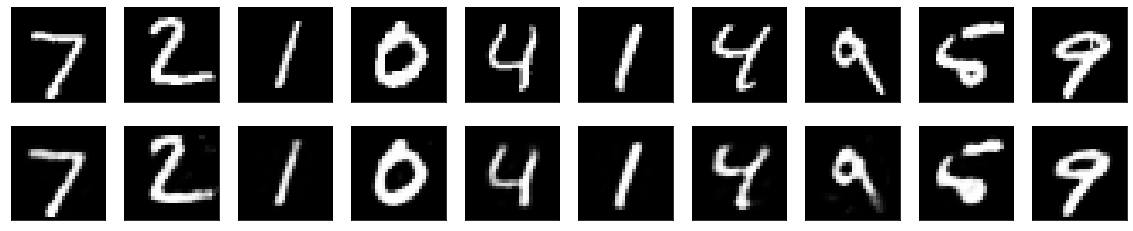

In [ ]:
decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

## Глубокий автоэнкодер

А что, если попробовать в автоэнкодере сделать несколько слоев? Тогда они смогут более эффективно находить нелинейные зависимости в наших картинках

In [ ]:
def create_deep_dense_ae():
    # Размерность кодированного представления
    encoding_dim = 49

    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*3, activation='relu')(flat_img)
    x = Dense(encoding_dim*2, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='linear')(x)

    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation='relu')(input_encoded)
    x = Dense(encoding_dim*3, activation='relu')(x)
    flat_decoded = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(flat_decoded)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

d_encoder, d_decoder, d_autoencoder = create_deep_dense_ae()
d_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

d_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 49)                134750    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         135485    
Total params: 270,235
Trainable params: 270,235
Non-trainable params: 0
_________________________________________________________________


Обучим модель

In [ ]:
d_autoencoder.fit(x_train, x_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.2279 - val_loss: 0.1470
Epoch 2/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.1327 - val_loss: 0.1203
Epoch 3/100
60000/60000 [==============================] - 7s 115us/step - loss: 0.1167 - val_loss: 0.1116
Epoch 4/100
60000/60000 [==============================] - 7s 114us/step - loss: 0.1089 - val_loss: 0.1042
Epoch 5/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.1033 - val_loss: 0.1002
Epoch 6/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.0997 - val_loss: 0.0968
Epoch 7/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.0970 - val_loss: 0.0945
Epoch 8/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.0947 - val_loss: 0.0933
Epoch 9/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0930 - val_

Снова посмотрим на то, как будут выглядеть наши картинки

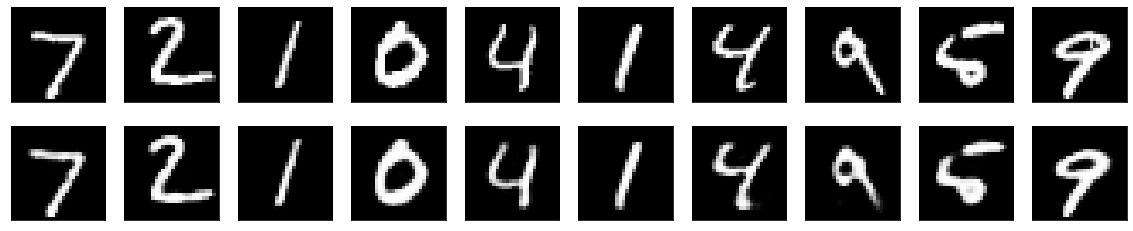

In [ ]:
n = 10

imgs = x_test[:n]
encoded_imgs = d_encoder.predict(imgs, batch_size=n)
encoded_imgs[0]

decoded_imgs = d_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

Картинки стали более похожи на оригинал, соответственно, и ошибка снизилась: с 0.0785 до 0.0748 на 50-й эпохе, а дальше стала еще ниже.

## Сверточный энкодер

Мы же работаем с картинками, а с ними во многих задачах хорошо справляются сверточные сетки. Давайте применим этот же подход для автоэнкодера

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

def create_deep_conv_ae():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)

    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное

    input_encoded = Input(shape=(7, 7, 1))
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

c_autoencoder.summary()



Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 7, 7, 1)           24385     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         24385     
Total params: 48,770
Trainable params: 48,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
c_autoencoder.fit(x_train, x_train,
                epochs=64,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/64
10496/60000 [====>.........................] - ETA: 25:27 - loss: 0.3721

In [ ]:
n = 10

imgs = x_test[:n]
encoded_imgs = c_encoder.predict(imgs, batch_size=n)
decoded_imgs = c_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

Итого - параметров меньше, качество выше.

## Denoising autoencoder

Давайте рассмотрим еще одну задачу, которую могут решать автоэнкодеры - очистка картинок от шума. Для этого нужно всего лишь на вход автоэнкодеру подавать зашумленные данные, а на выход - изначальные.

In [ ]:
import keras.backend as K
from keras.layers import Lambda

batch_size = 16

def create_denoising_model(autoencoder):
    # функция, которая добавляет шум на картинку
    def add_noise(x):
        noise_factor = 0.5
        x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        x = K.clip(x, 0., 1.)
        return x

    input_img  = Input(batch_shape=(batch_size, 28, 28, 1))
    # собсно, на этом слое и добавляем шум
    noised_img = Lambda(add_noise)(input_img)

    noiser = Model(input_img, noised_img, name="noiser")
    denoiser_model = Model(input_img, autoencoder(noiser(input_img)), name="denoiser")
    return noiser, denoiser_model


noiser, denoiser_model = create_denoising_model(autoencoder)
denoiser_model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
denoiser_modeler_model.summary()

In [ ]:
denoiser_model.fit(x_train, x_train,
                   epochs=200,
                   batch_size=batch_size,
                   shuffle=True,
                   validation_data=(x_test, x_test))

In [ ]:
n = 10

imgs = x_test[:batch_size]
noised_imgs = noiser.predict(imgs, batch_size=batch_size)
encoded_imgs = encoder.predict(noised_imgs[:n],  batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs[:n], batch_size=n)

plot_digits(imgs[:n], noised_imgs, decoded_imgs)

Итак, шум убран успешно

## Другие автоэнкодеры

Мы рассмотрели только малую часть задач, которые могут быть решены с использованием автоэнкодера. В общем случае так же работает и перенос стиля изображения, и любое другое изменение и восстановление размерности данных